In [117]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
#import lifetimes
#import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [118]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)

In [45]:
methods = ['phone' , 'email' , 'apple' , 'google' , 'facebook' ]

In [59]:
query = """

select
 date_event_nk,
 login_method,
 count(distinct session_long) as qty_user
  from ods.panameraolx_asia_hydra_ninja_ios_last_month
where trackevent='login_sign_in_complete'
 and country_sk = 'olx|asia|in'
group by 1,2
order by 2,1


"""

In [60]:
lv = pd.read_sql_query(query.replace('%', '%%'), engine)
lv['total_by_day'] = lv.groupby(['date_event_nk'])['qty_user'].transform('sum')
lv['share_by_method'] = lv['qty_user'] / lv['total_by_day']

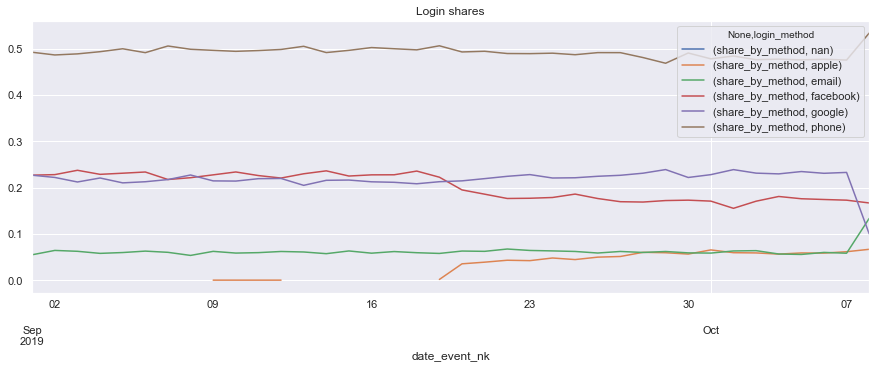

In [64]:
lv[['date_event_nk' ,'login_method' ,  'share_by_method']].set_index(['date_event_nk' , 'login_method']).unstack().plot(figsize=(15,5) , title='Login shares')

In [93]:
lv['date_event_nk'] = pd.to_datetime(lv['date_event_nk'])
lv_post = lv[lv['date_event_nk'] > '2019-09-22'].pivot_table(index='login_method' , values=['qty_user' , 'total_by_day'], aggfunc='sum')
lv_pre = lv[lv['date_event_nk'] < '2019-09-20'].pivot_table(index='login_method' , values=['qty_user' , 'total_by_day'], aggfunc='sum')
lv_pre = lv_pre[lv_pre.index != 'apple']

def share_login_method(df):
    df['login_share'] = df['qty_user'] / df['total_by_day']
    return df

lv_post = share_login_method(lv_post)
lv_pre  = share_login_method(lv_pre)

lv_post['applesignin'] = 1
lv_pre['applesignin'] = 0

,qty_user,total_by_day,login_share,applesignin
0,7950,143426,0.055429,1
1,8677,143426,0.060498,1
2,24824,143426,0.173079,1
3,32871,143426,0.229184,1
4,69104,143426,0.481809,1


In [104]:
lvs = pd.concat([lv_pre , lv_post])[['login_share' , 'applesignin']].reset_index()

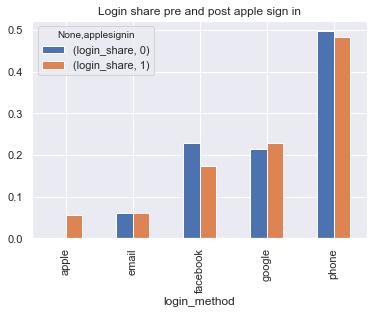

In [110]:
lvs.set_index(['login_method','applesignin']).unstack().fillna(0).plot(kind='bar' , title='Login share pre and post apple sign in')

In [112]:
lvs.set_index(['login_method','applesignin']).unstack().fillna(0)

login_share          
applesignin            0         1
login_method                      
apple           0.000000  0.055429
email           0.059779  0.060498
facebook        0.227999  0.173079
google          0.215441  0.229184
phone           0.496647  0.481809

In [14]:
query = """

WITH verified AS (
    SELECT session
from ods.panameraolx_asia_hydra_ninja_ios_last_month
WHERE trackevent in ('onboarding_show' , 'login_show') and country_sk='olx|asia|in'
)
SELECT
  date_event_nk,
  COUNT(DISTINCT CASE WHEN trackevent in ('onboarding_show' , 'login_show') THEN session_long ELSE NULL END) AS login_onboar_show,
  COUNT(DISTINCT CASE WHEN trackevent = 'login_sign_in_complete' THEN session_long ELSE NULL END) AS login_complete
FROM ods.panameraolx_asia_hydra_ninja_ios_last_month h
INNER JOIN verified t ON h.session=t.session
  where country_sk='olx|asia|in'
 group by 1
order by 1


"""

In [15]:
dfin = pd.read_sql_query(query.replace('%', '%%'), engine)

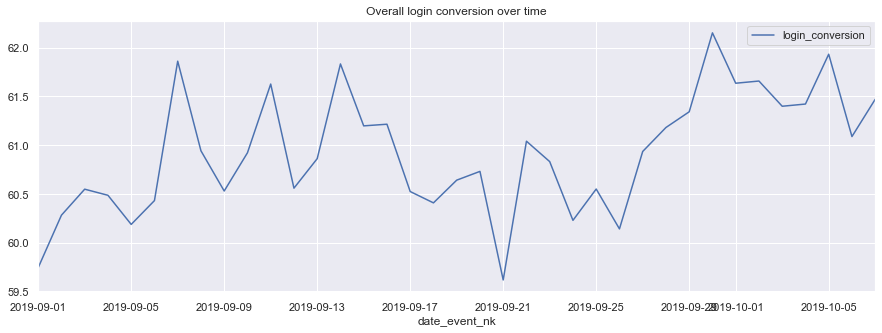

In [111]:
dfin['login_conversion'] = (dfin['login_complete'] / dfin['login_onboar_show'])*100
login_conversion = dfin[['date_event_nk' , 'login_conversion']].set_index('date_event_nk')
login_conversion.plot(figsize=(15,5) , title='Overall login conversion over time')


In [123]:
query = """

WITH verified AS (
    SELECT session
from ods.panameraolx_asia_hydra_ninja_ios_last_month
WHERE trackevent in ('login_sign_in_start') and country_sk='olx|asia|in' and login_method='{0}'
 and app_version in (select app_version from ods.panameraolx_asia_hydra_ninja_ios_last_month
                         where country_sk='olx|asia|in' and login_method='apple'
                         group by 1)
)
SELECT
  date_event_nk,
  COUNT(DISTINCT CASE WHEN trackevent in ('login_sign_in_start') THEN session_long ELSE NULL END) AS login_onboar_show,
  COUNT(DISTINCT CASE WHEN trackevent = 'login_sign_in_complete' THEN session_long ELSE NULL END) AS login_complete
FROM ods.panameraolx_asia_hydra_ninja_ios_last_month h
INNER JOIN verified t ON h.session=t.session
  where country_sk='olx|asia|in' 
     and login_method='{0}'
 group by 1
order by 1


"""

In [124]:
result = []
for method in methods:
    q = query.format(method)
    lc = pd.read_sql_query(q, engine)
    lc['login_method'] = method
    result.append(lc)
    

In [125]:
lc = pd.concat(result)
lc['login_conversion'] = lc['login_complete'] / lc['login_onboar_show']

In [126]:
lcp = lc[['date_event_nk' , 'login_method' , 'login_conversion']].set_index(['date_event_nk' , 'login_method']).unstack().fillna(0)

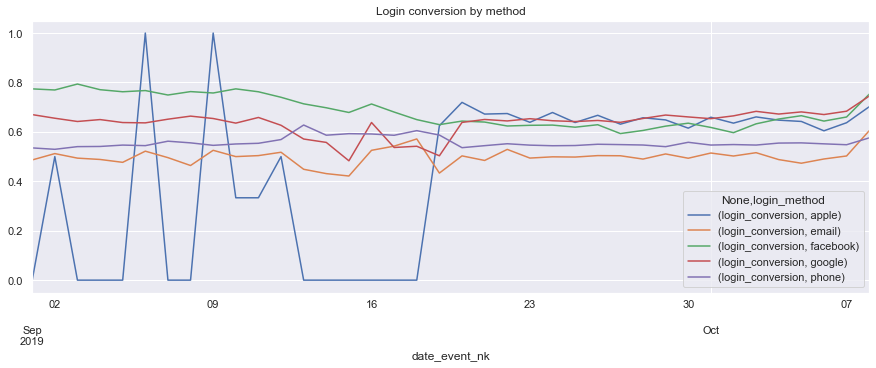

In [127]:
lcp.plot(figsize=(15,5) , title='Login conversion by method')